In [2]:
#------------------------------------------------------------------------------#
# Title:        Group Project - Music Genre Classification                     #
# Course:       COMP9444 Neural Networks 2022 Term Three                       #
# Session:      Thursday 16:00 - 18:00                                         #
#                                                                              #
# Team:         NNKing                                                         #
# Author/s:     Peter Huang (z5313504)                                         #
#               Fiona O’Chee (z5122503)                                        #
#               Evan Karl Lam (z5333206)                                       #
#               Theo Graftieaux (z5258743)                                     #
#               Oliver Guo (z5191682)                                          #
#                                                                              #
#------------------------------------------------------------------------------#

# Overview

### Usage Guide

No execution required; all results are already displayed for convenience. 





# Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/COMP9444/COMP9444-Group-Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1f2FfExUGYN2E54Q1zrEAFNotNfq9wlni/COMP9444/COMP9444-Group-Project


In [4]:
!ls # Confirm in project root directory

input  main.ipynb  models  output


In [5]:
import time
import os
import warnings
import IPython.display as ipd
import tqdm.notebook
import ast
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import glob
import h5py
import seaborn as sns
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
import sklearn as skl
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score

In [60]:
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [7]:
INPUT_DIR = 'input'

In [8]:
# Helper function to conveniently load raw data into dataframes.
# (adapted from source: https://github.com/mdeff/fma)
def load(filepath):
    filename = os.path.basename(filepath)

    if 'features' in filename:
        # Use rows 0, 1 and 2 to comprise feature headings
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for c in columns:
            tracks[c] = tracks[c].map(ast.literal_eval)

        columns = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for c in columns:
            tracks[c] = pd.to_datetime(tracks[c])

        subsets = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=subsets, ordered=True)
        except (ValueError, TypeError):
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=subsets, ordered=True))

        columns = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for c in columns:
            tracks[c] = tracks[c].astype('category')

        return tracks

In [9]:
# Load data from 3 FMA files which comprise the raw dataset.
df_tracks = load(f'{INPUT_DIR}/fma_metadata/tracks.csv')
df_features = load(f'{INPUT_DIR}/fma_metadata/features.csv')

# Check matching dimensions
# np.testing.assert_array_equal(df_features.index, df_tracks.index) 
# assert df_echonest.index.isin(df_tracks.index).all()

In [10]:
# Filters for selecting specific row instances 
filter_small = df_tracks.index[df_tracks['set', 'subset'] <= 'small']
filter_train = df_tracks[('set', 'split')] == 'training'
filter_val = df_tracks[('set', 'split')] == 'validation'
filter_test = df_tracks[('set', 'split')] == 'test'

# Filter for fma_small specific music tracks only
df_tracks = df_tracks.loc[filter_small]
df_features = df_features.loc[filter_small]

# Split datasets into training, validation, testing sets.
# Note: While this is a preprocessing stage step it is 
# intentionally done early here (before exploratory data analysis) to guard 
# against Data Snooping Bias. By hiding validation and test data and only exploring 
# training data, we avoid stumbling upon interesting test set patterns which could 
# bias towards optimistic generalization error estimates.
df_tracks_train = df_tracks[filter_train]
df_tracks_validation = df_tracks[filter_val]
df_tracks_test = df_tracks[filter_test]
df_features_train = df_features.loc[filter_train]
df_features_val = df_features.loc[filter_val]
df_features_test = df_features.loc[filter_test]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Exploratory Data Analysis

The raw dataset is provided by FMA and is composed from 3 separate files:

* tracks.csv
* features.csv
* echonest.csv

Source: fma_metadata.zip from https://github.com/mdeff/fma

### General

This sub-section aims to gain a general understanding of the raw data.

#### Tracks Dataset

In [11]:
# Keep training set pristine; make copy solely for data exploration
df_tracks_exploration = df_tracks_train.copy()

In [12]:
# 52 features in tracks.csv
df_tracks_exploration.shape

(6400, 52)

In [13]:
# Shows that FMA features in tracks.csv are organised (via MultiIndex) in a top 
# and sub property hierarchy, arranged as tuples
# e.g album has "sub-features" comments, date_created, ..., tags, etc
df_tracks_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 2 to 155066
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   (album, comments)            6400 non-null   int64         
 1   (album, date_created)        6400 non-null   datetime64[ns]
 2   (album, date_released)       4161 non-null   datetime64[ns]
 3   (album, engineer)            955 non-null    object        
 4   (album, favorites)           6400 non-null   int64         
 5   (album, id)                  6400 non-null   int64         
 6   (album, information)         5231 non-null   category      
 7   (album, listens)             6400 non-null   int64         
 8   (album, producer)            1159 non-null   object        
 9   (album, tags)                6400 non-null   object        
 10  (album, title)               6400 non-null   object        
 11  (album, tracks)              6400 non-nul

In [14]:
# Summary statistics for numerical features
df_tracks_exploration.describe(include=np.number)

# Shows no missing values, outliers, suggest FMA dataset creator conveniently 
# already cleaned the dataset.

album                                                         \
          comments    favorites            id        listens       tracks   
count  6400.000000  6400.000000   6400.000000    6400.000000  6400.000000   
mean      0.528594     1.869219  13618.313125   38797.147344    11.173125   
std       1.388609     3.350438   5966.399303   64825.872121     8.105938   
min       0.000000     0.000000      1.000000    1008.000000     1.000000   
25%       0.000000     0.000000   9328.000000    8054.000000     6.000000   
50%       0.000000     1.000000  15015.000000   16931.000000     9.000000   
75%       0.000000     2.000000  18530.000000   39066.500000    14.000000   
max      12.000000    29.000000  22899.000000  595875.000000    47.000000   

            artist                                                       \
          comments    favorites            id     latitude    longitude   
count  6400.000000  6400.000000   6400.000000  2315.000000  2315.000000   
mean      2.576719    41.830312  13170.533438    39.005367   -41.263094   
std       6.406288   110.817564   6906.783168    19.092404    67.658223   
min       0.000000     0.000000      1.000000   -41.286460  -157.526855   
25%       0.000000     2.000000   7444.000000    38.890370   -80.160084   
50%       0.000000     7.000000  14070.500000    40.852505   -73.950000   
75%       2.000000    23.000000  19461.000000    48.172699    -0.127683   
max      55.000000   861.000000  24252.000000    65.201935   174.885971   

               track                                                       \
            bit_rate     comments     duration    favorites      interest   
count    6400.000000  6400.000000  6400.000000  6400.000000  6.400000e+03   
mean   266134.936094     0.067812   227.745000     6.363125  6.918060e+03   
std     60848.431950     0.527205    97.606551    17.999002  3.097571e+04   
min    105237.000000     0.000000    60.000000     0.000000  4.630000e+02   
25%    216918.250000     0.000000   161.000000     1.000000  1.855750e+03   
50%    266278.000000     0.000000   214.000000     3.000000  3.510000e+03   
75%    320000.000000     0.000000   276.250000     7.000000  6.856250e+03   
max    322541.000000    24.000000   600.000000   765.000000  1.991344e+06   

                                   
             listens       number  
count    6400.000000  6400.000000  
mean     4694.797969     5.433438  
std     11313.836217     5.957022  
min       196.000000     0.000000  
25%      1267.000000     2.000000  
50%      2505.000000     4.000000  
75%      4916.250000     8.000000  
max    433992.000000   128.000000

In [15]:
# Summary statistics for string and object based features
df_tracks_exploration.iloc[:, 1:].describe(include=object)

# Interpretation:
# These features not too useful for our project and represent metadata for each 
# track. We only care about genres

album                                                    \
            engineer      producer  tags                         title   
count            955          1159  6400                          6400   
unique           122           168   299                          1978   
top     Irene Trudel  Rob Weisberg    []  Carcrashlander Instrumentals   
freq             128           153  5342                            36   

                                                   artist                \
                                        associated_labels      location   
count                                                 670          4369   
unique                                                151           643   
top     Care in the Community Recordings, Gagarin Reco...  Brooklyn, NY   
freq                                                   54           141   

                                        \
            members               name   
count          2676               6400   
unique          717               1885   
top     Chad Crouch  Blue Dot Sessions   
freq             38                208   

                                                           \
                                         related_projects   
count                                                 585   
unique                                                142   
top     Ratatat, Lullatone, Nightmares On Wax, Air, Mo...   
freq                                                   38   

                             ...       set        track                    \
                       tags  ...     split     composer genres genres_all   
count                  6400  ...      6400          153   6400       6400   
unique                 1852  ...         1           59    526        408   
top     [blue dot sessions]  ...  training  Chad Crouch   [21]       [21]   
freq                    208  ...      6400           27    487        487   

                                                                         \
                                              information language_code   
count                                                 150           759   
unique                                                103            12   
top     <p>http://www.peterbiedermann.com http://www.w...            en   
freq                                                    7           698   

                                                          
             lyricist             publisher  tags  title  
count              19                    65  6400   6400  
unique              9                    15   299   6235  
top     Apache Tomcat  Victrola Dog (ASCAP)    []  Intro  
freq                9                    27  5342     12  

[4 rows x 22 columns]

In [16]:
# Grasp general structure, values and data types of properties for each track.
df_tracks_exploration.head()

# Interpretation: tracks.csv contains metadata on each track. Some attributes 
# could serve as features (e.g tags, artist), but these will not be used for 
# training as the project goal is to classify based on the music itself. 

# Only 'genre_top' (which is applicable for our FMA dataset size choice) will 
# be used via a later track_id join with features.csv, serving as our target 
# output variable y.

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4   6   
140             1 2008-11-26 01:49:59    2007-05-22      NaN         1  61   
141             0 2008-11-26 01:49:57    2009-01-16      NaN         1  60   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
140       <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141       <p>A full ensamble of strings, drums, electron...    1304   

                                               ...       track           \
                                producer tags  ... information interest   
track_id                                       ...                        
2                                    NaN   []  ...         NaN     4656   
5                                    NaN   []  ...         NaN     1933   
10                                   NaN   []  ...         NaN    54881   
140       Alec K. Refearn, Rob Pemberton   []  ...         NaN     1593   
141                                  NaN   []  ...         NaN      839   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
10                  en  Attribution-NonCommercial-NoDerivatives (aka M...   
140                 en  Attribution-Noncommercial-No Derivative Works ...   
141                 en  Attribution-Noncommercial-No Derivative Works ...   

                                                                     
         listens lyricist number publisher tags               title  
track_id                                                             
2           1293      NaN      3       NaN   []                Food  
5           1151      NaN      6       NaN   []          This World  
10         50135      NaN      1       NaN   []             Freeway  
140         1299      NaN      2       NaN   []  Queen Of The Wires  
141          725      NaN      4       NaN   []                Ohio  

[5 rows x 52 columns]

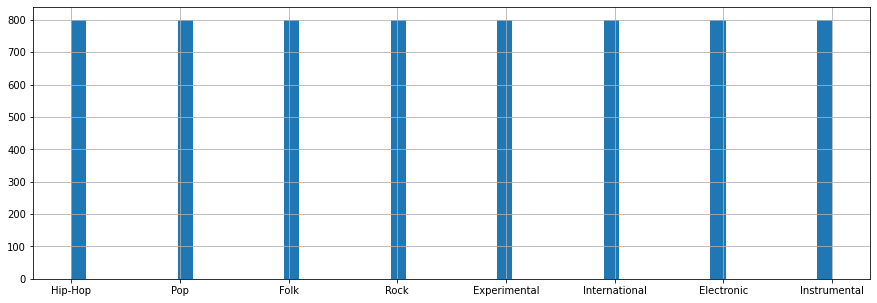

In [17]:
# Confirms we ar dealing with 8 balanced genre classes
df_tracks_exploration['track']['genre_top'].hist(bins=50, figsize=(15, 5))

In [18]:
# Analyse missing data for each tracks.csv feature
missing_counts = df_tracks_exploration.isnull().sum().sort_values(ascending=False)
missing_percent = (df_tracks_exploration.isnull().sum()/df_tracks_exploration.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_counts, round(missing_percent * 100, 2)], axis=1, keys=['Missing Count', 'Missing Percent'])
missing_data

# Interpretation:
# Can see high percentage of missing data for many features. But again not an issue;
# The only columns we need is genre_top, the table showing 
# missing values = 0 for both.

Missing Count  Missing Percent
track  lyricist                    6381            99.70
       publisher                   6335            98.98
       information                 6250            97.66
       composer                    6247            97.61
artist active_year_end             6130            95.78
       wikipedia_page              6086            95.09
track  date_recorded               6017            94.02
artist related_projects            5815            90.86
       associated_labels           5730            89.53
track  language_code               5641            88.14
album  engineer                    5445            85.08
       producer                    5241            81.89
artist active_year_begin           5237            81.83
       longitude                   4085            63.83
       latitude                    4085            63.83
       members                     3724            58.19
album  date_released               2239            34.98
artist location                    2031            31.73
       bio                         1646            25.72
       website                     1234            19.28
album  information                 1169            18.27
       type                         160             2.50
track  license                        5             0.08
       interest                       0             0.00
       genres_all                     0             0.00
       listens                        0             0.00
       number                         0             0.00
       genres                         0             0.00
       genre_top                      0             0.00
       favorites                      0             0.00
       duration                       0             0.00
       tags                           0             0.00
       date_created                   0             0.00
album  comments                       0             0.00
track  comments                       0             0.00
       bit_rate                       0             0.00
album  favorites                      0             0.00
       id                             0             0.00
       listens                        0             0.00
       tags                           0             0.00
       title                          0             0.00
       tracks                         0             0.00
artist comments                       0             0.00
       date_created                   0             0.00
       favorites                      0             0.00
       id                             0             0.00
       name                           0             0.00
album  date_created                   0             0.00
artist tags                           0             0.00
set    split                          0             0.00
       subset                         0             0.00
track  title                          0             0.00

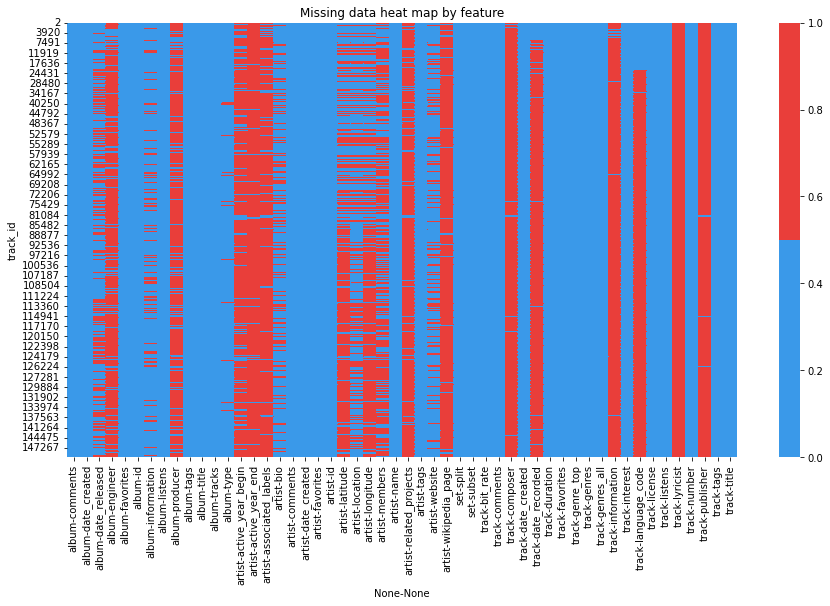

In [19]:
# Create missing data heat map
cols = df_tracks_exploration.columns # last 10 columns
colours = ['#3A99E9', '#E93E3A']

fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Missing data heat map by feature')
sns.heatmap(df_tracks_exploration[cols].isnull(), cmap=sns.color_palette(colours), ax=ax)

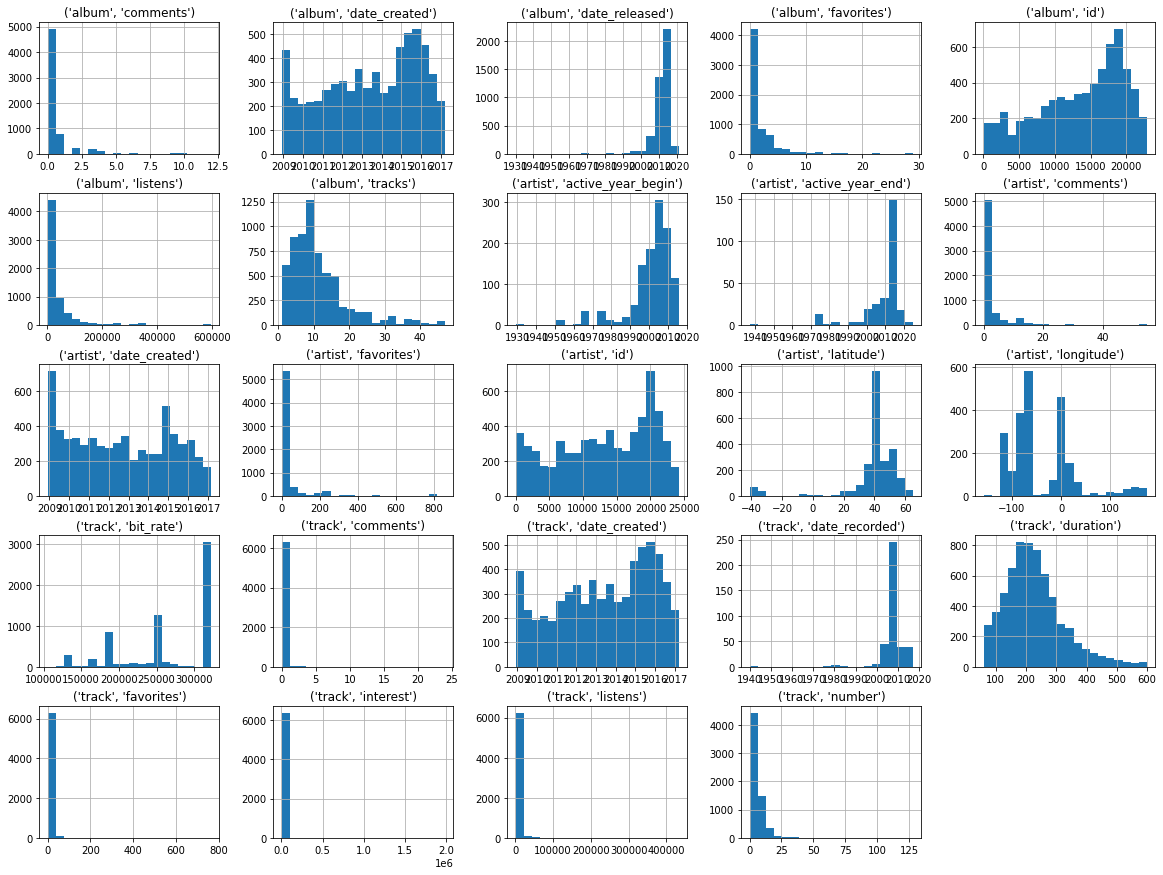

In [20]:
# Histograms for numerical features to look at shapes
df_tracks_exploration.hist(bins=20, figsize=(20,15))
plt.show()

In [ ]:
# Correlations visualization for numerical features
corr = df_tracks_exploration.corr()
colour = plt.cm.Reds
colour.set_bad('grey')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Feature correlations")
sns.heatmap(corr, annot=True, cmap=colour)

#### Features Dataset

This section explores features.csv.

In [22]:
# Filter such that only track_ids in df_tracks_exploration are 
# explored (otherwise, tracks from the larger datasets (fma_medium, fma_full, etc)
# are incorrectly included
df_features_exploration = df_features.loc[df_tracks_exploration.index]

In [23]:
# 518 features in features.csv
df_features_exploration.shape

(6400, 518)

In [43]:
df_features_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 2 to 155066
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 25.3 MB


In [46]:
# Summary statistics for numerical features
df_features_exploration.describe(include=np.number)

feature     chroma_cens                                                      \
statistics     kurtosis                                                       
number               01           02           03           04           05   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.113076     0.010020     0.221931     0.004531     0.060549   
std            1.494449     1.781823     6.749477     1.265560     1.602992   
min           -1.803165    -1.816620    -1.825738    -1.760243    -1.781202   
25%           -0.695136    -0.731209    -0.690802    -0.697518    -0.726482   
50%           -0.215258    -0.285382    -0.212749    -0.264542    -0.272076   
75%            0.443522     0.331971     0.453489     0.342889     0.382920   
max           31.833519    71.231590   517.172424    26.313240    43.405674   

feature                                                                      \
statistics                                                                    
number               06           07           08           09           10   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.058261     0.022015     0.145247     0.003180     0.082799   
std            1.473980     2.197019     3.096839     1.864111     1.991303   
min           -1.681459    -1.744581    -1.745497    -1.802878    -1.744567   
25%           -0.693577    -0.730509    -0.694883    -0.742993    -0.727792   
50%           -0.233024    -0.302746    -0.240300    -0.318084    -0.257539   
75%            0.401543     0.323283     0.435043     0.317136     0.403157   
max           34.192524   101.148888   188.753738    74.518082    75.878792   

feature     ...      tonnetz                                    zcr  \
statistics  ...          std                               kurtosis   
number      ...           04           05           06           01   
count       ...  6400.000000  6400.000000  6400.000000  6400.000000   
mean        ...     0.103494     0.021786     0.022069    29.630722   
std         ...     0.036546     0.005762     0.005741    56.726171   
min         ...     0.014479     0.006234     0.006667    -1.790083   
25%         ...     0.076436     0.017557     0.017881     4.455668   
50%         ...     0.099201     0.020916     0.021362    12.135332   
75%         ...     0.126006     0.025205     0.025543    32.301075   
max         ...     0.279182     0.053139     0.071633  1575.385254   

feature                                                                      \
statistics          max         mean       median          min         skew   
number               01           01           01           01           01   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.393299     0.051040     0.041780     0.002459     3.480475   
std            0.183086     0.029187     0.028077     0.004758     2.805224   
min            0.032715     0.003969     0.000000     0.000000    -3.143864   
25%            0.262695     0.032197     0.024414     0.000000     1.650729   
50%            0.366699     0.046224     0.036621     0.000977     2.717315   
75%            0.474121     0.063384     0.052734     0.003418     4.611065   
max            0.999512     0.629665     0.749512     0.170898    30.766621   

feature                  
statistics          std  
number               01  
count       6400.000000  
mean           0.040440  
std            0.025618  
min            0.002608  
25%            0.022873  
50%            0.034039  
75%            0.051502  
max            0.317725  

[8 rows x 518 columns]

In [25]:
df_features_exploration.columns

MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '05'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ...
            (    'tonnetz',      'std', '04'),
            (    'tonnetz',      'std', '05'),
            (    'tonnetz',      'std', '06'),
            (        'zcr', 'kurtosis', '01'),
            (        'zcr',      'max', '01'),
            (        'zcr',     'mean', '01'),
            (        'zcr',   'median', '01'),
            (        'zcr',      'min', '01'),
            (        'zcr',     'skew', '01'),
            (        'zcr',      'std', '01')],
           names=['feature', 'statistics', 

In [ ]:
df_features_exploration[0].hist(bins=50, figsize=(15, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f304476b690>,
      dtype=object)

In [ ]:
# Analyse missing data for each tracks.csv feature
missing_counts = df_features_exploration.isnull().sum().sort_values(ascending=False)
missing_percent = (df_features_exploration.isnull().sum()/df_features_exploration.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_counts, round(missing_percent * 100, 2)], axis=1, keys=['Missing Count', 'Missing Percent'])
missing_data

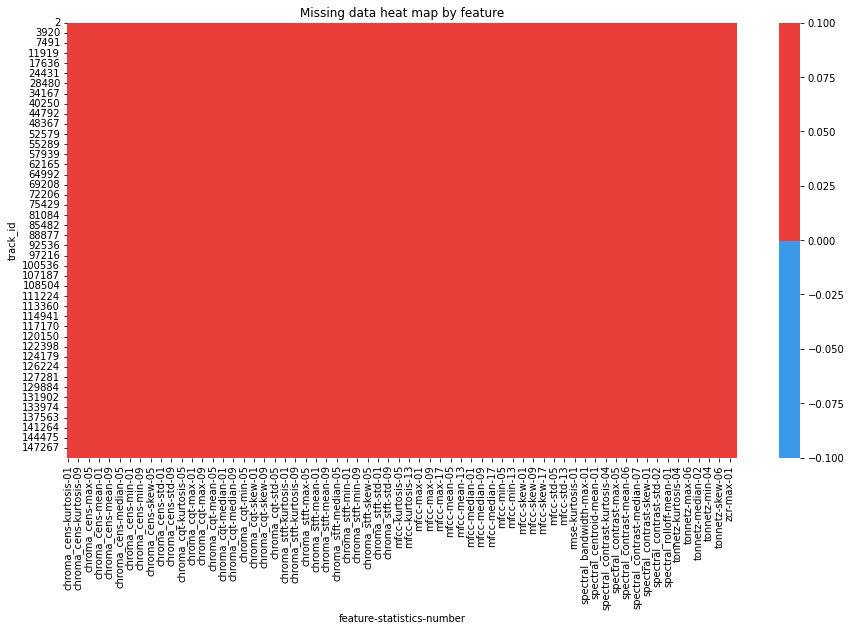

In [57]:
# Create missing data heat map
cols = df_features_exploration.columns # last 10 columns
colours = ['#3A99E9', '#E93E3A']

fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Missing data heat map by feature')
sns.heatmap(df_features_exploration[cols].isnull(), cmap=sns.color_palette(colours), ax=ax)

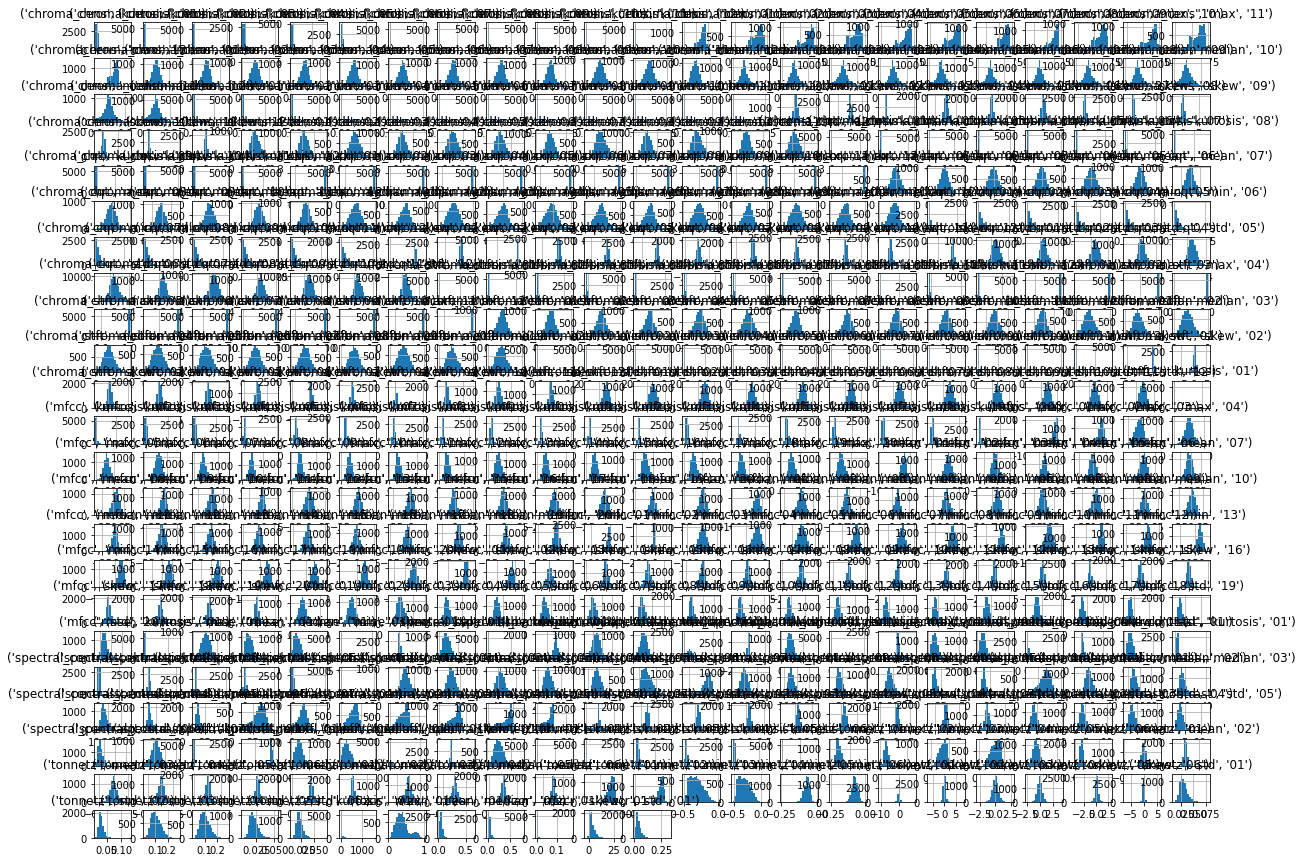

In [58]:
# Histograms for numerical features to look at shapes
df_features_exploration.hist(bins=20, figsize=(20,15))
plt.show()

In [ ]:
# Correlations visualization for numerical features
corr = df_features_exploration.corr()
colour = plt.cm.Reds
colour.set_bad('grey')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Feature correlations")
sns.heatmap(corr, annot=True, cmap=colour)

In [26]:
df_features_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 2 to 155066
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 25.3 MB


In [27]:
df_features_exploration.describe()

feature     chroma_cens                                                      \
statistics     kurtosis                                                       
number               01           02           03           04           05   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.113076     0.010020     0.221931     0.004531     0.060549   
std            1.494449     1.781823     6.749477     1.265560     1.602992   
min           -1.803165    -1.816620    -1.825738    -1.760243    -1.781202   
25%           -0.695136    -0.731209    -0.690802    -0.697518    -0.726482   
50%           -0.215258    -0.285382    -0.212749    -0.264542    -0.272076   
75%            0.443522     0.331971     0.453489     0.342889     0.382920   
max           31.833519    71.231590   517.172424    26.313240    43.405674   

feature                                                                      \
statistics                                                                    
number               06           07           08           09           10   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.058261     0.022015     0.145247     0.003180     0.082799   
std            1.473980     2.197019     3.096839     1.864111     1.991303   
min           -1.681459    -1.744581    -1.745497    -1.802878    -1.744567   
25%           -0.693577    -0.730509    -0.694883    -0.742993    -0.727792   
50%           -0.233024    -0.302746    -0.240300    -0.318084    -0.257539   
75%            0.401543     0.323283     0.435043     0.317136     0.403157   
max           34.192524   101.148888   188.753738    74.518082    75.878792   

feature     ...      tonnetz                                    zcr  \
statistics  ...          std                               kurtosis   
number      ...           04           05           06           01   
count       ...  6400.000000  6400.000000  6400.000000  6400.000000   
mean        ...     0.103494     0.021786     0.022069    29.630722   
std         ...     0.036546     0.005762     0.005741    56.726171   
min         ...     0.014479     0.006234     0.006667    -1.790083   
25%         ...     0.076436     0.017557     0.017881     4.455668   
50%         ...     0.099201     0.020916     0.021362    12.135332   
75%         ...     0.126006     0.025205     0.025543    32.301075   
max         ...     0.279182     0.053139     0.071633  1575.385254   

feature                                                                      \
statistics          max         mean       median          min         skew   
number               01           01           01           01           01   
count       6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean           0.393299     0.051040     0.041780     0.002459     3.480475   
std            0.183086     0.029187     0.028077     0.004758     2.805224   
min            0.032715     0.003969     0.000000     0.000000    -3.143864   
25%            0.262695     0.032197     0.024414     0.000000     1.650729   
50%            0.366699     0.046224     0.036621     0.000977     2.717315   
75%            0.474121     0.063384     0.052734     0.003418     4.611065   
max            0.999512     0.629665     0.749512     0.170898    30.766621   

feature                  
statistics          std  
number               01  
count       6400.000000  
mean           0.040440  
std            0.025618  
min            0.002608  
25%            0.022873  
50%            0.034039  
75%            0.051502  
max            0.317725  

[8 rows x 518 columns]

In [28]:
# Display top level features
df_features_exploration.columns.levels[0]

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

In [29]:
# Shows each audio feature is sub-featured in terms of a statistical measure, such as kurtosis and skew.
list(df_features_exploration.columns)

[('chroma_cens', 'kurtosis', '01'),
 ('chroma_cens', 'kurtosis', '02'),
 ('chroma_cens', 'kurtosis', '03'),
 ('chroma_cens', 'kurtosis', '04'),
 ('chroma_cens', 'kurtosis', '05'),
 ('chroma_cens', 'kurtosis', '06'),
 ('chroma_cens', 'kurtosis', '07'),
 ('chroma_cens', 'kurtosis', '08'),
 ('chroma_cens', 'kurtosis', '09'),
 ('chroma_cens', 'kurtosis', '10'),
 ('chroma_cens', 'kurtosis', '11'),
 ('chroma_cens', 'kurtosis', '12'),
 ('chroma_cens', 'max', '01'),
 ('chroma_cens', 'max', '02'),
 ('chroma_cens', 'max', '03'),
 ('chroma_cens', 'max', '04'),
 ('chroma_cens', 'max', '05'),
 ('chroma_cens', 'max', '06'),
 ('chroma_cens', 'max', '07'),
 ('chroma_cens', 'max', '08'),
 ('chroma_cens', 'max', '09'),
 ('chroma_cens', 'max', '10'),
 ('chroma_cens', 'max', '11'),
 ('chroma_cens', 'max', '12'),
 ('chroma_cens', 'mean', '01'),
 ('chroma_cens', 'mean', '02'),
 ('chroma_cens', 'mean', '03'),
 ('chroma_cens', 'mean', '04'),
 ('chroma_cens', 'mean', '05'),
 ('chroma_cens', 'mean', '06'),
 ('c

In [30]:
df_features_exploration.shape

(6400, 518)

In [31]:
df_features_exploration.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
140        -0.882913 -0.582376 -0.884749 -0.645214  ...  0.157683  0.028070   
141        -0.204884  0.023624 -0.642770 -0.786291  ...  0.145994  0.024342   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
140         0.025946  11.052547  0.379395  0.052379  0.036621  0.001953   
141         0.032111  32.994659  0.415527  0.040267  0.034668  0.002930   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
5           2.193303  0.044861  
10          3.542325  0.040800  
140         3.143968  0.057712  
141         4.204097  0.028665  

[5 rows x 518 columns]

In [32]:
df_mfcc = df_features_exploration['mfcc']
df_mfcc.head()

statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
2           3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
5           2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10          5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
140         0.384906  1.203378  0.429393  0.639471 -0.080144 -0.440946   
141        -0.038922  4.771146 -0.378949 -0.309047 -0.661308 -0.531602   

statistics                                          ...        std            \
number            07        08        09        10  ...         11        12   
track_id                                            ...                        
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609  8.601942   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638  9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734  7.985110   
140        -0.432567 -0.126163  0.507695  0.408915  ...   9.883532  8.250456   
141         0.029186  0.662524 -0.084562  0.965640  ...   9.464321  8.119837   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
140         8.085891  8.114858  8.832722  8.157245  7.297486  7.734456   
141         8.918522  8.059117  9.339061  8.451561  8.426965  8.341757   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
5           8.452527  7.334442  
10          6.430473  6.186294  
140         7.807103  7.986255  
141         8.572934  9.351485  

[5 rows x 140 columns]

In [33]:
df_mfcc.shape

(6400, 140)

(8000,) (8000,) (8000,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


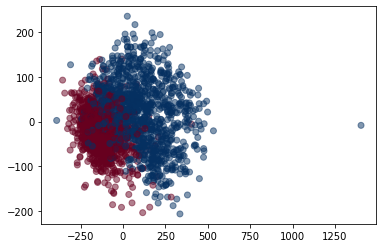

((2000, 2), (2000,))

In [34]:
small = df_tracks['set', 'subset'] <= 'small'
genre_Instrumental = df_tracks['track', 'genre_top'] == 'Instrumental'
genre2_HH = df_tracks['track', 'genre_top'] == 'Hip-Hop'

print(small.shape, genre_Instrumental.shape, genre2_HH.shape)

X = df_features.loc[small & (genre_Instrumental | genre2_HH), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = df_tracks.loc[small & (genre_Instrumental | genre2_HH), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
plt.show()
X.shape, y.shape

# Data Preprocessing

### General

In [35]:
# Random seed for repeated execution reproducibility 
RANDOM_SEED = 42

In [36]:
genres = list(LabelEncoder().fit(df_tracks['track', 'genre_top']).classes_)
print('Genres ({}): {}'.format(len(genres), genres))

Genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [37]:
def preprocess_pipeline(tracks, features, columns):
    # Encode each genre with an integer
    enc = LabelEncoder()
    genres = tracks['track', 'genre_top']

    # Split into training, validation and testing sets
    y_train = enc.fit_transform(genres[df_train])
    y_val = enc.transform(genres[df_val])
    y_test = enc.transform(genres[df_test])
    X_train = df_features.loc[df_train, columns].values
    X_val = df_features.loc[df_val, columns].values
    X_test = df_features.loc[df_test, columns].values
    X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_SEED)
    
    # Standardize features, removing mean (to 0) and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

In [38]:
df_train = df_tracks_train.index
df_val = df_tracks_validation.index
df_test = df_tracks_test.index

print('Dataset split: {} training, {} validation, {} testing'.format(*map(len, [df_train, df_val, df_test])))

Dataset split: 6400 training, 800 validation, 800 testing


### Spectrograms (For CRNN Model)

In [39]:
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

"""
Get track IDs from the mp3s in a directory.
"""
def get_trackIDs_from_dir(audio_dir):
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

In [42]:
track_ids = get_trackIDs_from_dir(f"{INPUT_DIR}/fma_small")
len(track_ids)  # should return 8 * 1000 = 8000, 1000 songs per genre

8000

In [ ]:
keep_cols = [
    ('set', 'split'),
    ('set', 'subset'),
    ('track', 'genre_top')
]

filepath = 'input/fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

In [ ]:
grouped_df = df_all.groupby(('track', 'genre_top')).first().reset_index()
grouped_df.head(15)

In [ ]:
def plot_spectogram(track_id, genre):
    filename = get_audio_path(f"{INPUT_DIR}/fma_small", track_id)
    y, sr = librosa.load(filename)
    print(len(y),sr)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    print(spect.shape, genre)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(str(genre))
    plt.show()

In [ ]:
plot_spectogram(2, 'Hip-Hop') # Create spectogram for track 2

In [ ]:
# Visualize differences in spectrograms for each genre
for index, row in grouped_df.iterrows():
    track_id = int(row['track_id'])
    genre = row[('track', 'genre_top')]
    plot_spectogram(track_id, genre)

### Spectrogram for All Files (For LSTM model)

In [ ]:
'''
Read and convert file into melspectrogram, return as numpy array
'''
def read_convert_melspec(file_name,title = None):
  try:
    x,sr = librosa.load(file_name,sr = None)
  except:
    print(f"Can't read {file_name}")
    return None

  if title is None:
    title = file_name[:-4]
  spect = librosa.feature.melspectrogram(y=x, sr=sr,n_fft=2048, hop_length=1024)
  spect = librosa.power_to_db(spect, ref=np.max)
  return spect

In [ ]:
'''
Read and store all file path and store in a list
'''
def read_all_file():
  total_audio_list = []
  for i in range(156):
    if i < 10:
      string = "00"+str(i)
    elif i < 100:
      string = "0"+str(i)
    else :
      string = str(i)
    list_file = glob.glob(f"{INPUT_DIR}/fma_small/{string}/*.mp3")
    total_audio_list.extend(list_file)

In [ ]:
'''
Assign audio from all directory to each genre group, based on the csv file
'''
def assign_audio_to_genre(total_audio_list,top_genre):
  seperate_genre_dict = {}
  for i in top_genre:
    seperate_genre_dict[i] = []

  for i in total_audio_list:
    for j in seperate_genre_dict.keys():
      try:
        if tracks[('track', 'genre_top')][int(i[-10:-4].lstrip('0'))] == j:
          seperate_genre_dict[j].append(i)
          continue
      except Exception as e:
        print(f"Exception {e}and the string is {i}")
        break

In [ ]:
'''
preprocess data and store them into hdf5 file
'''
def write_genre_hdf(genre_list,genre_name):
  list_store = []
  for i in genre_list:
    converted = read_convert_melspec(i)
    if converted is None:
      continue
    temp = {"name":i,"mel_spec":converted}

    list_store.append(temp)

  file_name = "mel_spec/"+genre_name+".hdf5"

  h = h5py.File(file_name, 'w')
  group = h.create_group(genre_name)
  for item in list_store:

    group.create_dataset(item["name"].replace("/","-"),data = item["mel_spec"])
  h.close()

In [ ]:
genre_list = df_tracks['track']['genre_top']
total_audio_list = read_all_file()
separate_genre_dict = assign_audio_to_genre(total_audio_list, genre_list)

In [ ]:
'''
Convert all to json file, there will be a file for each music genre
'''
for keys, values in list(separate_genre_dict.items):
    write_genre_hdf(values, keys)

In [ ]:
'''
Reading the data out,
return a list of dictionary, each dictionary contains the name and preprocessed data
'''
def read_hdf(file_path):
    return_dict = []
    with h5py.File(file_path, 'r') as hf:
        print(list(hf.keys()))
        dataset = hf[file_path[9:-5]]
        print(len(list(dataset.keys())))
        keys = list(dataset.keys())
        for i in keys:
            return_dict.append({
                "name":i.replace("-","/"),
                "data":dataset[i][:]
            })
        return return_dict

# Model Selection, Tuning and Evaluation

### Baseline (Classical ML)

This purpose of this section is to implement a variety of machine learning models, which are then used as a baseline for performance comparison with neural network based classifiers to follow.

In [ ]:
# List of classical machine learning model candidates to use as baseline
classifiers = {
    'LR': LogisticRegression(max_iter=10000),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'SVCrbf': SVC(kernel='rbf'),
    'SVCpoly1': SVC(kernel='poly', degree=1),
    'linSVC1': SVC(kernel="linear"),
    'linSVC2': LinearSVC(),
    'DT': DecisionTreeClassifier(max_depth=5),
    'NB': GaussianNB(),
     # Also consider ensemble based methods
    'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
}

In [ ]:
# TODO: Improve this by using subsets per: "Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
      #  'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
      #  'spectral_rolloff', 'tonnetz', 'zcr'],
feature_subsets = {}
for subset in df_features.columns.levels[0]:
    feature_subsets[subset] = subset
    feature_subsets.update({
        'mfcc/contrast': ['mfcc', 'spectral_contrast'],
        'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
        'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
        'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
        'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
        'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
        'all': list(df_features.columns.levels[0])
    })

In [ ]:
# Helper function, highlights the top scoring for each feature subset in model-feature matrix
def format_matrix_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: green' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.1%}', subset = pd.IndexSlice[:, scores.columns[1]:])

In [ ]:
baseline_models = list(classifiers.keys())
# Additionally, display number of features used as first column
baseline_models = baseline_models.insert(0, 'numFeatures')

# Setup dataframe to show scores in a matrix, with models as columns and 
# feature subsets as rows
acc_scores_matrix = pd.DataFrame(columns=baseline_models, index=feature_subsets.keys())

In [ ]:
# Train, build score matrix and make predictions for each model and feature subset combination
for fsubset_name, fsubset in tqdm.notebook.tqdm(feature_subsets.items(), desc='feature subset'):
  y_train, y_val, y_test, X_train, X_val, X_test = preprocess_pipeline(df_tracks, df_features, fsubset)
  acc_scores_matrix.loc[fsubset_name, 'numFeatures'] = X_train.shape[1]
  for clf_name, clf in classifiers.items(): 
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      acc = clf.score(X_test, y_test)
      prec = precision_score(y_test, y_pred, average="macro")
      cm = confusion_matrix(y_test, y_pred)
      # Use macro F1 score since micro essentially covered by accuracy, and 
      # we care about each genre equally
      f1 = f1_score(y_test, y_pred, average="macro")

      # Add result into scores matrix (for display in next cell)
      acc_score s_matrix.loc[fsubset_name, clf_name] = acc

      print(f"\nClassifer: {clf_name}, fsubset: {fsubset_name}")
      print(f"Accuracy: {acc:.3f}")
      print(f"Precision: {prec:.3f}")
      print(f"F1 score (macro): {f1:.3f}") 

      # Visualise confusion matrices for each combination
      cm = cm / cm.astype(float).sum(axis=1) # Normalize values between 0 and 1
      plt.figure().suptitle(f"Model: {clf_name}, Feature Subset: {fsubset_name}", fontsize="small")
      sns.set(font_scale=0.8)
      sns.heatmap(cm, annot=True, xticklabels=genres, yticklabels=genres, fmt='')
      plt.show()

In [ ]:
# Show accuracy scores for each model vs feature subset combination
# in one convenient table 
ipd.display(format_matrix_scores(acc_scores_matrix))

### Neural Networks

#### CNN

In [ ]:
'''
Since the task is not overly ccomplex, choose to use LeNet 5
'''
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
# inputs = keras.Input(shape=input_shape) 

def model(input_shape,label_reference):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(len(label_reference), activation='softmax'))
    return model
model = model(input_shape,label_reference)
optimizer = keras.optimizers.SGD(learning_rate = 0.0009)
model.compile(optimizer = optimizer, loss = "SparseCategoricalCrossentropy",metrics = ["accuracy"])

'''
Fit and train data
'''
model.fit(x_train,y_train,validation_data = (x_valid,y_valid),epochs=30,batch_size = 4)

'''
Check result
'''
error,accuracy = model.evaluate(x_test[0:4],y_test[0:4],verbose = 1)
print(f"Error is {error} and accuracy is {accuracy}")
def predict_list(test_list):
    prediction = model.predict(test_list)
    prediction = [np.argmax(i) for i in prediction]
    return prediction
prediction_class = predict_list(x_test)
real_class = list(y_test.flatten())

precision = precision_score(real_class,prediction_class,average="macro")
recall = recall_score(real_class,prediction_class,average="macro")
f1_score = f1_score(real_class,prediction_class,average="macro")
accuracy = accuracy_score(real_class, prediction_class)   
print_evaluation_metrics("CNN",accuracy,precision,recall,f1_score)

#### LSTM

#### Transfer Learning Approach

In [ ]:
import os
import numpy as np
from os.path import isfile

from fastai.vision.all import *

import seaborn as sns

# from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
npz_file = np.load('input/shuffled_train.npz')

X_train = npz_file['arr_0'] # get array from the first file 
y_train = npz_file['arr_1'] # get array from the second file

print(X_train.shape, y_train.shape)
print(X_train[0])
print(y_train[0])

(6394, 640, 128) (6394, 8)
[[ -5.16850536  -4.31890804  -4.77122094 ... -18.42068074 -18.42068074
  -18.42068074]
 [ -2.48283322  -2.07804404  -4.08614045 ... -18.42068074 -18.42068074
  -18.42068074]
 [ -2.49017317  -1.37799711  -1.68048832 ... -12.72401852 -14.37600593
  -16.06189915]
 ...
 [-18.42068074 -18.42068074 -18.42068074 ... -18.42068074 -18.42068074
  -18.42068074]
 [-18.42068074 -18.42068074 -18.42068074 ... -18.42068074 -18.42068074
  -18.42068074]
 [-13.03971004 -10.76111878  -9.74584907 ... -14.56515575 -16.74693547
  -18.42068074]]
[1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
npz_valid_file = np.load('input/shuffled_valid.npz')

X_valid = npz_valid_file['arr_0']
y_valid = npz_valid_file['arr_1']

print(X_valid.shape, y_valid.shape)
print(X_valid[0])
print(y_valid[0])

(800, 640, 128) (800, 8)
[[ -7.52773372  -7.07302297  -7.13632417 ... -17.21551444 -18.42068074
  -18.42068074]
 [ -6.68254481  -4.10279465  -1.77462616 ... -14.50561104 -16.13628929
  -18.42068074]
 [-10.00745455  -4.66620972  -1.69349652 ... -14.79143959 -16.29503197
  -18.42068074]
 ...
 [ -8.30887068  -8.00224235  -5.84288788 ... -14.52635066 -16.49676518
  -18.42068074]
 [ -8.91541544  -7.94720273  -5.05552613 ... -15.35461841 -16.94068164
  -18.42068074]
 [ -8.72121266  -8.120174    -5.69182602 ... -14.82019335 -16.26787683
  -18.42068074]]
[0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
genres_dict = {
    'Electronic': 0, 
    'Experimental': 1, 
    'Folk': 2, 
    'Hip-Hop': 3, 
    'Instrumental': 4,
    'International': 5, 
    'Pop': 6, 
    'Rock': 7  
}

reverse_genres_dic = {v: k for k, v in genres_dict.items()}

def make_dataloaders_from_numpy_data(image, label):

    def get_x(i):
        return(image[i])

    def get_y(i):
        for idx, x in enumerate(label[i]):
            if (x == 1.0):
                genre = reverse_genres_dic[idx]
                # print(genre)
                return(genre)    

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=get_x,
        get_y=get_y)

    # pass in a list of index
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)))

    print(dls.train.vocab)

    return dls

dls = make_dataloaders_from_numpy_data(X_train, y_train)

['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [ ]:
precision = Precision(average="macro")
recall = Recall(average="macro")
f1_score = F1Score(average="macro")
learner = vision_learner(dls, models.resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, precision, recall, f1_score])

In [ ]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.326291,1.856797,0.451487,0.444001,0.454870,0.441654,40:43


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.672981,1.485596,0.537559,0.539678,0.539833,0.534406,47:50


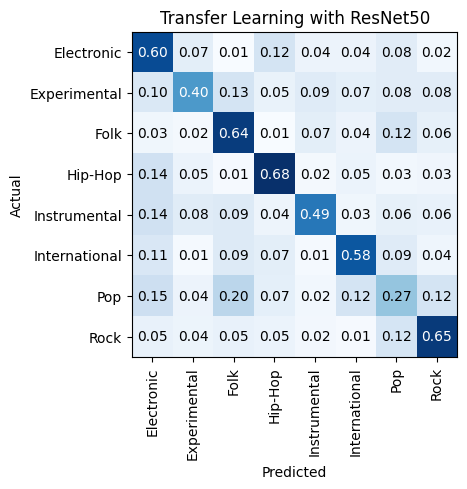

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title="Transfer Learning with ResNet50", normalize=True)

#### GRU

#### CRNN

##### Prepare Mel-Spectrogram for each song(30s)

In [ ]:
import os
import numpy as np
from os.path import isfile

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda

from keras import backend
from keras.layers import ELU
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import librosa
import librosa.display

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
genres_dict = {
    'Electronic': 0, 
    'Experimental': 1, 
    'Folk': 2, 
    'Hip-Hop': 3, 
    'Instrumental': 4,
    'International': 5, 
    'Pop': 6, 
    'Rock': 7  
}

reverse_genres_dic = {v: k for k, v in genres_dict.items()}

In [ ]:
npz_file = np.load('input/shuffled_train.npz')
print(npz_file.files) # two arrays stored
X_train = npz_file['arr_0'] # get array from the first file 
y_train = npz_file['arr_1'] # get array from the second file
print(X_train.shape, y_train.shape)

In [ ]:
npz_valid_file = np.load('input/shuffled_valid.npz')
# print(npz_valid_file.files)
X_valid = npz_valid_file['arr_0']
y_valid = npz_valid_file['arr_1']
print(X_valid.shape, y_valid.shape)

In [ ]:
# Check by plotting a Spectogram
num = 5300
spectogram = X_train[num]
genre_index = np.argmax(y_train[num])

print(reverse_genres_dic[genre_index])

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

##### Implementation

In [ ]:
# Hyperparameters
batch_size = 32
num_classes = 8   # 8 genres classes in total
n_features = X_train.shape[2]
n_time = X_train.shape[1]

N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 100
NUM_HIDDEN = 64
L2_regularization = 0.001

In [ ]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    # LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    # Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    # Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(learning_rate=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [ ]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
show_summary_stats(history)

##### Evaluation

In [ ]:
y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
print(accuracy_score(y_true, y_pred))

##### Evaluate Test Set

In [ ]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

In [ ]:
npzfile = np.load('input/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

In [ ]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

In [ ]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0, 1, 2, 3, 4, 5, 6, 7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

In [ ]:
print(accuracy_score(y_true, y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalise
sns.heatmap(cmn.T, square=True, annot=True, fmt='.2f', cbar=True,
            xticklabels=genres_dict.keys(),
            yticklabels=genres_dict.keys())
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Summary, Insights and Conclusions